## 형용사 및 부사 제거된 문장 만들기
품사 스케일링은 다음과 같이 진행한다.
1. 개별 sentence에 대해 pos-tagging을 수행한다.(분석기 4가지 버전으로)
2. 이 중 형용사, 부사를 문장에서 제거한다. 단, entity는 제외
3. 형용사와 부사를 제거한 토큰을 이어 붙인다. 이 때, 띄어쓰기가 손상되었을 가능성이 있으므로 띄어쓰기 보정을 추가한다(옵션)
3. 스케일링된 train set으로 baseline을 학습하고 성능을 확인한다.

라이브러리 준비

In [ ]:
# !pip install git+https://github.com/haven-jeon/PyKoSpacing.git #PyKoSpacing(딥러닝 코퍼스 학습 기반)-->에러떠서 바로 바꿈
# !pip install git+https://github.com/ssut/py-hanspell.git #Py-Hanspell(네이버 맞춤법 검사기 기반)

In [1]:
import pandas as pd
# import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns
import ast
from ast import literal_eval
from collections import Counter
import warnings

from tqdm.auto import trange
from time import sleep

# from pykospacing import Spacing
from hanspell import spell_checker

from konlpy.tag import Okt, Komoran, Kkma, Hannanum

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.4f' % x) #4자리까지만


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


전처리 함수 모음

In [2]:
# limit 이하의 개수인 label만 포함하는 데이터프레임 출력
def accept_label(dataset,limit=200):
    """except label이 아닌 label(relation) 문장만 포함한 데이터프레임 출력"""
    # ver 1. dataframe
    # df_cnt = pd.DataFrame(dataset['label'].value_counts())
    # df_cnt = df_cnt.reset_index(drop=False)
    # df_cnt.columns = ['label','count']
    # # print(df_cnt.head())
    # acc_label = df_cnt.loc[df_cnt['count']<=limit,'label']
    # acc_label = list(acc_label)
    
    # ver 2. counter
    
    df_cnt = Counter(dataset['label'])
    acc_label = [label for idx,label in enumerate(df_cnt) if df_cnt[label]<=limit]
    print(f"Use {len(acc_label)} labels")

    # labels = dataset.loc[:,'label']
    # idx_label = [idx for idx,label in enumerate(labels) if label not in acc_label]
    # print(len(dataset),len(idx_label))
    
    df = dataset.loc[dataset['label'].isin(acc_label),:]
    df = df.reset_index(drop=True)
    return df

# entity-->>word, stt_idx, end_idx, type으로 쪼개기
def eval_entity(df):
    """딕셔너리 형태의 entity를 쪼개 word, stt_idx, end_idx, type을 각각 칼럼으로 추가하는 함수"""

    df['subject_word'] = [literal_eval(entity)['word'] for entity in df['subject_entity']]
    df['subject_stt_idx'] = [literal_eval(entity)['start_idx'] for entity in df['subject_entity']]
    df['subject_end_idx'] = [literal_eval(entity)['end_idx'] for entity in df['subject_entity']]
    df['subject_type'] = [literal_eval(entity)['type'] for entity in df['subject_entity']]

    df['object_word'] = [literal_eval(entity)['word'] for entity in df['object_entity']]
    df['object_stt_idx'] = [literal_eval(entity)['start_idx'] for entity in df['object_entity']]
    df['object_end_idx'] = [literal_eval(entity)['end_idx'] for entity in df['object_entity']]
    df['object_type'] = [literal_eval(entity)['type'] for entity in df['object_entity']]
    # print(df.columns)
    return df
    
# subject_entity의 stt_idx와 object entity의 stt_idx에 각각 토큰 집어넣기
def tokenize_entity(sentence,sub_idx,ob_idx):
    """문장을 subject, object의 토큰으로 치환하는 함수
    sentence: str |-->input 문장
    sub_idx: list(stt,end) |-->subject 인덱스
    ob_idx: list(stt,end) |-->object 인덱스"""
    sub_stt, sub_end = sub_idx
    ob_stt, ob_end = ob_idx
    
    if sub_stt < ob_stt: # sub가 ob보다 앞에 있을 때
        sentence = sentence[:sub_stt]+'subject'+sentence[sub_end+1:]
        l = 7 - (sub_end-sub_stt+1)
        ob_stt += l
        ob_end += l
        sentence = sentence[:ob_stt]+'object'+sentence[ob_end+1:]
    else:
        sentence = sentence[:ob_stt]+'subject'+sentence[ob_end+1:]
        l = 7 - (ob_end-ob_stt+1)
        sub_stt += l
        sub_end += l
        sentence = sentence[:sub_stt]+'object'+sentence[sub_end+1:]
    return sentence

# 토큰화 문장을 태깅하고 형용사/부사를 제거하는 함수
def PosTag_token(sentence,tag='okt',drop_pos=['Adjective','Adverb'],norm=True,pacing=True):
    """문장을 태깅 후 성분 제거하는 함수
    sentence: pd.Series |-->idx기반 dataframe의 행"""

    taggers = {'okt':Okt(), 'kom':Komoran(), 'kkm':Kkma(), 'han':Hannanum()}
    tagg = taggers[tag]
    sentence_pos = tagg.pos(sentence,norm=norm)
    result = []
    drop = False

    for idx,(word,pos) in enumerate(sentence_pos):
        if pos in drop_pos:
            drop=True
            continue
        else:
            result.append(word)

    if not drop:
        return result, drop

    #띄어쓰기 보정
    elif pacing:
        result = ''.join(result)

        # spacing = Spacing()
        # result = spacing(result)
        
        spelled_sent = spell_checker.check(result)
        result = spelled_sent.checked

        #subject, object 보정
        if result.find('subject')<0:
            for i in range(1,7):
                sub = 'subject'
                sub = sub[:i] + ' ' + sub[i:]
                if result.find(sub)!=-1:
                    result = result.replace(sub,'subject')
        if result.find('object')<0:
            for i in range(1,6):
                ob = 'object'
                ob = ob[:i] + ' ' +ob[i:]
                if result.find(ob)!=-1:
                    result = result.replace(ob,'object')
            # if result.find('o bject')>=0:
            #     result = result.replace('o bject','object')
            # elif result.find('ob ject')>=0:
            #     result = result.replace('ob ject','object')
            # elif result.find('obj ect')>=0:
            #     result = result.replace('obj ect','object')
            # elif result.find('obje ct')>=0:
            #     result = result.replace('obje ct','object')
            # elif result.find('objec t')>=0:
            #     result = result.replace('objec t','object')
        
    else:
        result = ' '.join(result)
    return result,drop

# 토큰 다시 치환하기
def back_tokenize(sentence,subject_word,object_word):
    """subject, object 토큰을 원래 단어로 치환하는 함수"""
    if sentence.find('subject')<sentence.find('object'): #sub가 앞에 있을 때
        sub_stt_idx = sentence.find('subject')
        sub_end_idx = sub_stt_idx+len(subject_word)-1
        ob_stt_idx = sentence.find('object') - (7-len(subject_word))
        ob_end_idx = ob_stt_idx+len(object_word)-1
    else:
        ob_stt_idx = sentence.find('object')
        ob_end_idx = ob_stt_idx+len(object_word)-1
        sub_stt_idx = sentence.find('subject') - (7-len(object_word))
        sub_end_idx = sub_stt_idx+len(subject_word)-1
        
    # subject = sentence.split('subject')
    # if len(subject)!=2:
    #     return print(subject)
    # else:
    #     subject_pre,subject_end = subject#sentence.split('subject')
    #     result = subject_pre+subject_word+subject_end
    subject_pre,subject_end = sentence.split('subject')
    result = subject_pre+subject_word+subject_end

    # object = result.split('object')
    # if len(object)!=2:
    #     return print(object)
    # else:
    #     object_pre,object_end = object #result.split('object')
    #     result = object_pre+object_word+object_end
    object_pre,object_end = result.split('object')
    result = object_pre+object_word+object_end

    return result, sub_stt_idx, sub_end_idx, ob_stt_idx, ob_end_idx

# 데이터프레임 처리
def pos_augmentation(data,exc_limit=200,tag='okt',drop_pos=['Adjective','Adverb'],norm=True,pacing=True):
    """데이터프레임 전처리"""
    
    # exc_label = except_label(data,limit=exc_limit)
    dataset = accept_label(data,limit=exc_limit)
    dataset = eval_entity(dataset)

    new_sentences = []
    new_sub_entity = []
    new_ob_entity = []
    new_labels = []
    new_sources = []

    #'id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source',
    #    'subject_word', 'subject_stt_idx', 'subject_end_idx', 'subject_type',
    #    'object_word', 'object_stt_idx', 'object_end_idx', 'object_type'

    for i in trange(len(dataset)):
        # sent = dataset.loc[i,'sentence']
        # sub_wd,sub_stt,sub_end,sub_type = dataset.loc[i,['subject_word','subject_stt_idx','subject_end_idx','subject_type']]
        # ob_wd,ob_stt,ob_end,ob_type = dataset.loc[i,['object_word','object_stt_idx','object_end_idx','object_type']]
        # label = dataset.loc[i,'label']
        # source = dataset.loc[i,'source']

        _,sent,_,_,label,source,sub_wd,sub_stt,sub_end,sub_type,ob_wd,ob_stt,ob_end,ob_type = dataset.iloc[i,:]

        new_sent = tokenize_entity(sent,[sub_stt,sub_end],[ob_stt,ob_end])
        new_sent,drop = PosTag_token(new_sent,tag=tag,drop_pos=drop_pos,norm=norm,pacing=pacing)
        if drop: #drop_pos 적용한 케이스
            new_sent,sub_stt,sub_end,ob_stt,ob_end = back_tokenize(new_sent,sub_wd,ob_wd)
            new_sentences.append(new_sent)
            new_sub_entity.append(str({'word':sub_wd,'start_idx':sub_stt,'end_idx':sub_end,'type':sub_type}))
            new_ob_entity.append(str({'word':ob_wd,'start_idx':ob_stt,'end_idx':ob_end,'type':ob_type}))
            new_labels.append(label)
            new_sources.append(source)
        else:
            continue
        sleep(0.01)


    add_rows = len(new_sentences)
    ids = list(range(len(data),len(data)+add_rows))
    
    new_df = pd.DataFrame({ 'id':ids,
                            'sentence':new_sentences,
                            'subject_entity':new_sub_entity,
                            'object_entity':new_ob_entity,
                            'label':new_labels,
                            'source':new_sources})

    return new_df  
    

In [46]:
# df = accept_label(train)
literal_eval(df.loc[0,'subject_entity'])['word']

'문성민'

### 최종 점검

In [22]:
# pos_augmentation 예제
train = pd.read_csv('./dataset/train/train.csv')
# test = pd.read_csv('./dataset/test/test_data.csv')
pos_augmentation(train.head(1000),exc_limit=30,pacing=False) #137 중 81번째에서 에러 발생

18


100%|██████████| 144/144 [03:36<00:00,  1.50s/it]


,id,sentence,subject_entity,object_entity,label,source
0,1000,뉴질랜드 1 차 산업부 생물 보안 대변인 캐서린 박사 는 과일 파리 를 잡기 위해 ...,"{'word': '뉴질랜드', 'start_idx': 0, 'end_idx': 3,...","{'word': '오클랜드', 'start_idx': 46, 'end_idx': 4...",org:members,wikitree
1,1001,"문성민 은 경기대 학교 에 입학 하여 황동일 , 신영석 과 경 기 대학교 의 전성기...","{'word': '문성민', 'start_idx': 0, 'end_idx': 2, ...","{'word': '경기대', 'start_idx': 6, 'end_idx': 8, ...",per:schools_attended,wikipedia
2,1002,로버트 조지 ( 바비 ) 실 ( Robert George ( Bobby )( Bob...,"{'word': '흑표당', 'start_idx': 103, 'end_idx': 1...","{'word': '휴이 뉴튼', 'start_idx': 109, 'end_idx':...",org:founded_by,wikipedia
3,1003,"1984년 에는 포스트시즌 을 포함 해 56 경기 324.2 이닝 , 31 승 , ...","{'word': '롯데 자이언츠', 'start_idx': 145, 'end_idx...","{'word': '1984년', 'start_idx': 153, 'end_idx':...",org:founded,wikipedia
4,1004,냉전 동안 독일 연방군 은 NATO 의 서유럽 방위 의 주력 군 이 되었으며 전군 ...,"{'word': '독일 연방군', 'start_idx': 6, 'end_idx': ...","{'word': '49만 5,000명', 'start_idx': 52, 'end_i...",org:number_of_employees/members,wikipedia
...,...,...,...,...,...,...
57,1057,한편 순천시 는 아이 들 부터 노년 까지 세대 맞춤 형 인구 정책 추진 으로 인구 ...,"{'word': '순천시', 'start_idx': 3, 'end_idx': 5, ...","{'word': '281534명', 'start_idx': 86, 'end_idx'...",org:number_of_employees/members,wikitree
58,1058,후 토 와 그 아들 네 명 ( 후지와라 4 형제 ) 에 후지와라 씨 의 번영 의 기...,"{'word': '쇼무 천황', 'start_idx': 73, 'end_idx': ...","{'word': '몬무 천황', 'start_idx': 81, 'end_idx': ...",per:other_family,wikipedia
59,1059,"이후 게임 마다 구성원 이 달라지는 것 이 특징 인데 , 《 KOF ' 96 》 에...","{'word': '쿠사나기 쿄', 'start_idx': 140, 'end_idx'...","{'word': '야가미 이오리', 'start_idx': 149, 'end_idx...",per:colleagues,wikipedia
60,1060,이윤영 의 총리 인준 이 지청천 은 이윤영 을 이승만 과 초대 내각 의 무임 소 장...,"{'word': '지청천', 'start_idx': 14, 'end_idx': 16...","{'word': '이승만', 'start_idx': 26, 'end_idx': 28...",per:colleagues,wikipedia


## Baseline 학습을 위한 전체 데이터셋 만들기

In [3]:
# index_modify 적용한 ver. train.csv
train = pd.read_csv('./dataset/train/train.csv')
train.loc[:,'label'].value_counts().tail(15)

per:date_of_death                      418
org:product                            380
per:children                           304
per:place_of_residence                 193
per:other_family                       190
per:place_of_birth                     166
org:founded_by                         155
per:product                            139
per:siblings                           136
org:political/religious_affiliation     98
per:religion                            96
per:schools_attended                    82
org:dissolved                           66
org:number_of_employees/members         48
per:place_of_death                      40
Name: label, dtype: int64

200 기준

In [29]:
train.columns

Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source'], dtype='object')

In [57]:
train_aug = pos_augmentation(train,exc_limit=200,pacing=False)
train_aug['label'].value_counts()

Use 12 labels


100%|██████████| 1409/1409 [35:19<00:00,  1.50s/it]


per:place_of_residence                 95
org:founded_by                         85
per:other_family                       75
per:siblings                           71
per:product                            69
per:religion                           56
org:political/religious_affiliation    52
per:place_of_birth                     52
per:schools_attended                   42
org:number_of_employees/members        37
org:dissolved                          36
per:place_of_death                     12
Name: label, dtype: int64

In [75]:
# train_aug.to_csv('./dataset/train/train_aug_pos200.csv',index=False,encoding='utf-8')

In [58]:
result = pd.concat([train,train_aug],axis=0).reset_index(drop=True)
result['label'].value_counts()

no_relation                            9534
org:top_members/employees              4284
per:employee_of                        3573
per:title                              2103
org:member_of                          1866
org:alternate_names                    1320
per:origin                             1234
org:place_of_headquarters              1195
per:date_of_birth                      1130
per:alternate_names                    1001
per:spouse                              795
per:colleagues                          534
per:parents                             520
org:founded                             450
org:members                             420
per:date_of_death                       418
org:product                             380
per:children                            304
per:place_of_residence                  288
per:other_family                        265
org:founded_by                          240
per:place_of_birth                      218
per:product                     

In [59]:
result.to_csv('./dataset/train/train_pos200.csv',index=False,encoding='utf-8', header=True)

400 기준

In [4]:
train_aug_400 = pos_augmentation(train,exc_limit=400,pacing=False)
train_aug_400['label'].value_counts()

Use 14 labels


100%|██████████| 2093/2093 [52:03<00:00,  1.49s/it]


org:product                            193
per:children                           136
per:place_of_residence                  95
org:founded_by                          85
per:other_family                        75
per:siblings                            71
per:product                             69
per:religion                            56
org:political/religious_affiliation     52
per:place_of_birth                      52
per:schools_attended                    42
org:number_of_employees/members         37
org:dissolved                           36
per:place_of_death                      12
Name: label, dtype: int64

In [ ]:
# train_aug_400.to_csv('./dataset/train/train_aug_pos400.csv',index=False,encoding='utf-8',header=True)

In [5]:
result400 = pd.concat([train,train_aug_400],axis=0).reset_index(drop=True)
result400['label'].value_counts()

no_relation                            9534
org:top_members/employees              4284
per:employee_of                        3573
per:title                              2103
org:member_of                          1866
org:alternate_names                    1320
per:origin                             1234
org:place_of_headquarters              1195
per:date_of_birth                      1130
per:alternate_names                    1001
per:spouse                              795
org:product                             573
per:colleagues                          534
per:parents                             520
org:founded                             450
per:children                            440
org:members                             420
per:date_of_death                       418
per:place_of_residence                  288
per:other_family                        265
org:founded_by                          240
per:place_of_birth                      218
per:product                     

In [6]:
result400.to_csv('./dataset/train/train_pos400.csv',index=False,encoding='utf-8',header=True)

레전드 13시간

In [35]:
# train_aug = pos_augmentation(train,exc_limit=200,pacing=False) #pacing 띄어쓰기 보정 오류나서 그냥 토큰 단위로 " " 보정함...
# result = pd.concat(train,train_aug,axis=0)
# result.shape


# 1차 시기-->acc_label 제대로 안 먹어서 no_relation 포함되었고 value_counts() 엉망이라 acc_label 수정-->13시간 10분 32초
# 100%|██████████| 31061/31061 [13:10:32<00:00,  1.53s/it]  


100%|██████████| 31061/31061 [13:10:32<00:00,  1.53s/it]  


## 4. 원본 train과 증강 result 비교

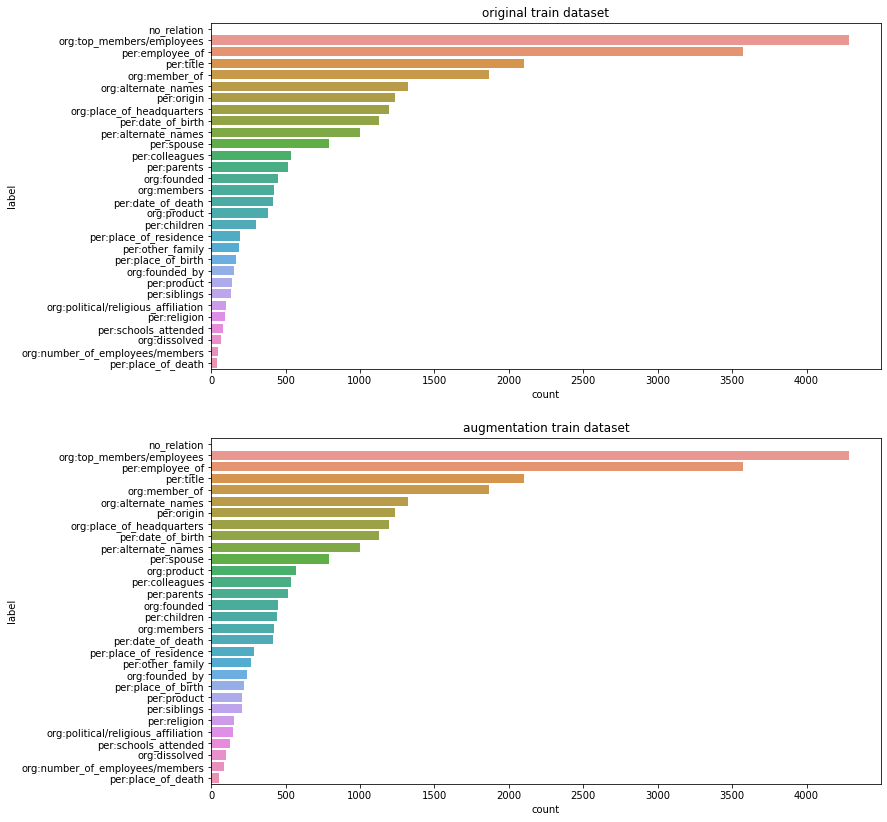

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,14))

plt.subplot(2,1,1)
sns.countplot(y='label',data=train.loc[train['label']!='no_relation',:],order=train['label'].value_counts().index)
plt.title('original train dataset')

plt.subplot(2,1,2)
sns.countplot(y='label',data=result400.loc[result400['label']!='no_relation',:],order=result400['label'].value_counts().index)
plt.title('augmentation train dataset')

plt.show()

불균형이 눈에 띄게 개선된 편은 아니다. 아무래도 개수가 적은 label이 대상이지만, 형용사와 부사가 포함된 문장만 제거된 버전으로 새로 생성되는 거라 문장 수가 크게 불어나지 않은 이유 때문인 것 같다.